<a href="https://colab.research.google.com/github/saniyaverma/Crop-Disease-Prediction-Model-Analysis/blob/main/Tomato_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import json
import shutil
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

In [ ]:
# Upload your kaggle.json first in Colab (use sidebar)

with open("kaggle.json", "r") as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

!kaggle datasets download -d kaustubhb999/tomatoleaf
!unzip -q tomatoleaf.zip

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
tomatoleaf.zip: Skipping, found more recently modified local copy (use --force to force download)
replace tomato/cnn_train.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Combine train and val folders into one
combined_path = "/content/tomato-leaf-disease"
train_path = "/content/tomato/train"
val_path = "/content/tomato/val"
os.makedirs(combined_path, exist_ok=True)

def combine_folders(source_dir, target_dir):
    for cls in os.listdir(source_dir):
        src_cls = os.path.join(source_dir, cls)
        dst_cls = os.path.join(target_dir, cls)
        os.makedirs(dst_cls, exist_ok=True)
        for file in os.listdir(src_cls):
            shutil.copy2(os.path.join(src_cls, file), os.path.join(dst_cls, file))

combine_folders(train_path, combined_path)
combine_folders(val_path, combined_path)

In [ ]:
def count_images(folder_path):
    total = 0
    for cls in sorted(os.listdir(folder_path)):
        path = os.path.join(folder_path, cls)
        count = len(os.listdir(path))
        print(f"{cls}: {count} images")
        total += count
    print(f"\nTotal images: {total}")

count_images(combined_path)

def check_image_integrity(folder_path):
    broken = []
    for cls in os.listdir(folder_path):
        for img in os.listdir(os.path.join(folder_path, cls)):
            try:
                with Image.open(os.path.join(folder_path, cls, img)) as im:
                    im.verify()
            except:
                broken.append(os.path.join(cls, img))
    print("Corrupt images:" if broken else "All images OK")
    if broken: print(broken)

check_image_integrity(combined_path)

Tomato___Bacterial_spot: 1100 images
Tomato___Early_blight: 1100 images
Tomato___Late_blight: 1100 images
Tomato___Leaf_Mold: 1100 images
Tomato___Septoria_leaf_spot: 1100 images
Tomato___Spider_mites Two-spotted_spider_mite: 1100 images
Tomato___Target_Spot: 1100 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1100 images
Tomato___Tomato_mosaic_virus: 1100 images
Tomato___healthy: 1100 images

Total images: 11000
All images OK


In [ ]:
IMAGE_SIZE = 299
BATCH_SIZE = 32
SEED = 123
EPOCHS = 20
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    combined_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

class_names = dataset.class_names
NUM_CLASSES = len(class_names)

# 80/10/10 split
total_batches = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * total_batches)
val_size = int(0.1 * total_batches)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 11000 files belonging to 10 classes.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Apply resize & rescale to all datasets
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

# Apply augmentation only to training
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=AUTOTUNE)

In [ ]:
from keras.applications import InceptionV3

base_model = InceptionV3(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.2)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 73, 73,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,823,274 (83.25 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 186s 627ms/step - accuracy: 0.1954 - loss: 2.2495 - val_accuracy: 0.4982 - val_loss: 1.7354
Epoch 2/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 168s 607ms/step - accuracy: 0.4830 - loss: 1.6712 - val_accuracy: 0.6103 - val_loss: 1.4327
Epoch 3/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 197s 590ms/step - accuracy: 0.5900 - loss: 1.3947 - val_accuracy: 0.6719 - val_loss: 1.2494
Epoch 4/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 160s 581ms/step - accuracy: 0.6421 - loss: 1.2258 - val_accuracy: 0.6838 - val_loss: 1.1384
Epoch 5/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 160s 580ms/step - accuracy: 0.6762 - loss: 1.1146 - val_accuracy: 0.7096 - val_loss: 1.0484
Epoch 6/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 199s 568ms/step - accuracy: 0.6978 - loss: 1.0300 - val_accuracy: 0.7261 - val_loss: 0.9872
Epoch 7/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 158s 573ms/step - accuracy: 0.6979 - loss: 0.9714 - val_accuracy: 0.7399 - val_loss: 0.9392
Epoch 8/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 209s 600ms/step - accuracy: 0.7201 -

In [ ]:
base_model.trainable = True

fine_tune_at = 249
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

Epoch 20/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 203s 642ms/step - accuracy: 0.5992 - loss: 1.2155 - val_accuracy: 0.8079 - val_loss: 0.5975
Epoch 21/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 170s 616ms/step - accuracy: 0.8349 - loss: 0.5138 - val_accuracy: 0.8695 - val_loss: 0.4205
Epoch 22/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 175s 632ms/step - accuracy: 0.8702 - loss: 0.3974 - val_accuracy: 0.8860 - val_loss: 0.3661
Epoch 23/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 177s 643ms/step - accuracy: 0.8978 - loss: 0.3380 - val_accuracy: 0.9062 - val_loss: 0.3006
Epoch 24/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 167s 606ms/step - accuracy: 0.9098 - loss: 0.2816 - val_accuracy: 0.9164 - val_loss: 0.2670
Epoch 25/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 210s 637ms/step - accuracy: 0.9170 - loss: 0.2511 - val_accuracy: 0.9320 - val_loss: 0.2257
Epoch 26/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 195s 611ms/step - accuracy: 0.9289 - loss: 0.2241 - val_accuracy: 0.9421 - val_loss: 0.2081
Epoch 27/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 174s 631ms/step - accuracy: 

In [ ]:
acc = history.history['accuracy'] +history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] +  history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] +  history_fine.history['val_loss']

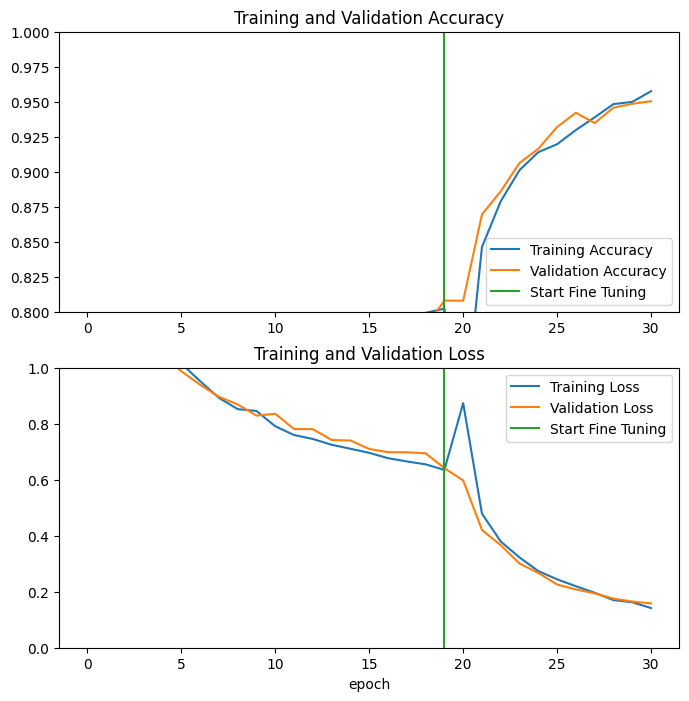

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to print


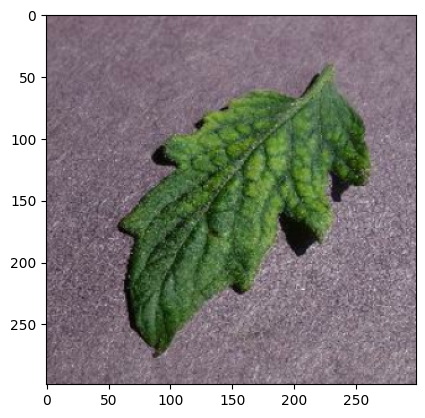

first image actual label: Tomato___Tomato_mosaic_virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
predicted label: Tomato___Tomato_mosaic_virus


In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy() * 255).astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to print")
    plt.imshow(first_image)
    plt.show()

    print("first image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


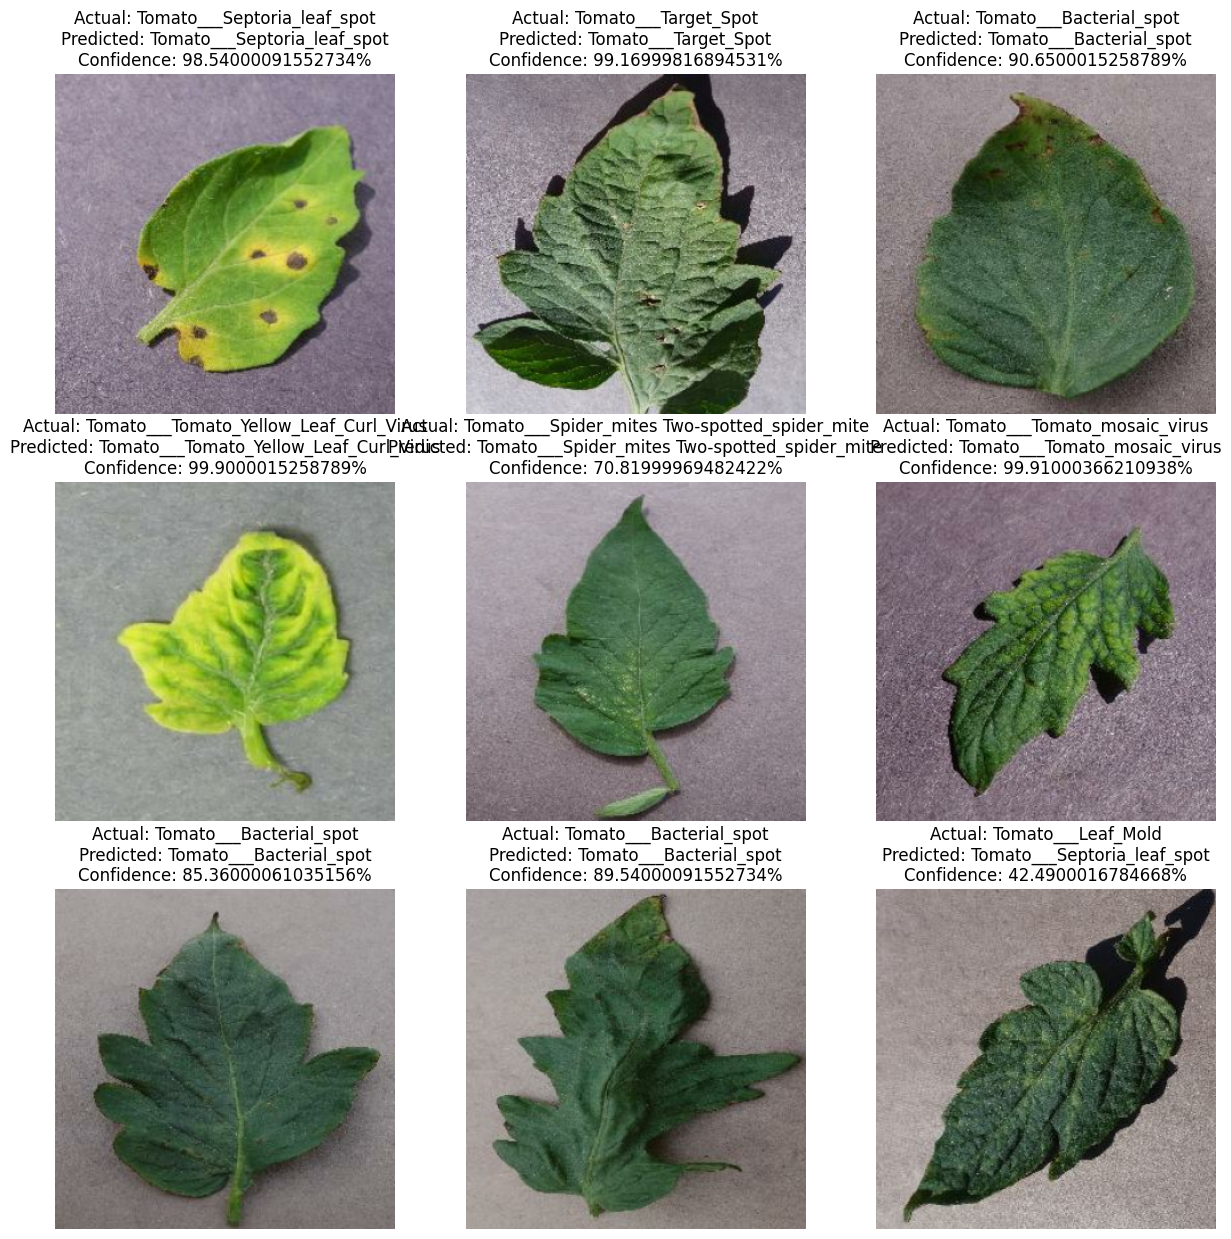

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # rescale for display
        display_image = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(display_image)

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

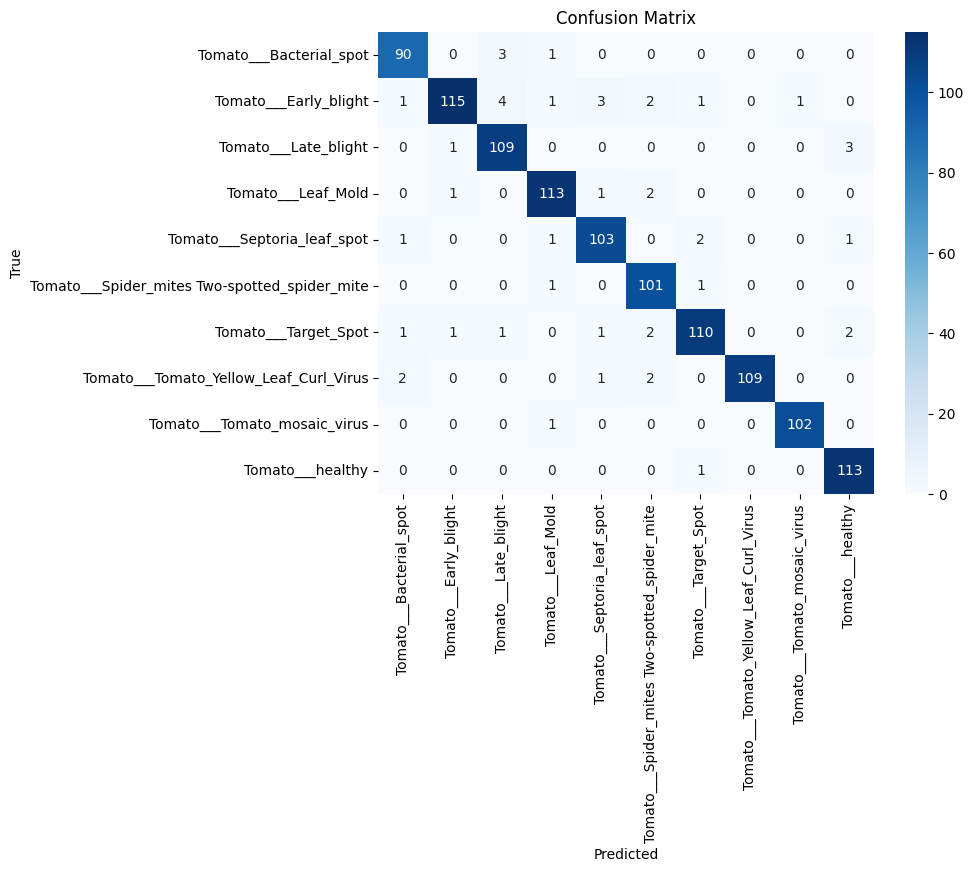

ROC-AUC Score: 99.89%


In [ ]:
y_true, y_pred, y_prob = [], [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_prob.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
print(f"Precision: {precision_score(y_true, y_pred, average='weighted')*100:.2f}%")
print(f"Recall: {recall_score(y_true, y_pred, average='weighted')*100:.2f}%")
print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')*100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"ROC-AUC Score: {auc_score*100:.2f}%")
except Exception as e:
    print("ROC-AUC not available:", e)

In [ ]:
model.save("tomato-leaf-disease_InceptionV3_model.keras")
print("Model saved successfully.")

Model saved successfully.
